# __Table Of Contents__

1. [Problem Context and Definition](#p-c-and-d)
2. [Literature Review](#literature-review)
3. [Initial Model](#initial-model)
4. [Problem Difficulty](#problem-difficulty)
5. [Phase One Improvements](#phase-one-improvements)
6. [Phase One Experiments](#phase-one-experiments)
7. [Phase One Results](#results)
8. [Phase Two Improvements](#phase-two-improvements)
9. [Phase Two Results](#phase-two---experimentation-and-results)
10. [Declaration of Contribution](#declaration-of-contribution)
11. [Addendum](#addendum---vertex-colouring)

# **Problem Context and Definition**

The problem of grouping frequently arises in the context of Structural Engineering. Buildings are made up of many different types of elements, such as beams, walls, slabs, and columns. Taking the example of columns, there can be many thousands of column elements, defined individually at each floor, in a given building. Structural engineers must design these elements based on many conditions such as strength (to ensure the element does not fail under specified loading conditions, such as snow loads), servicability (to ensure there is not excessive vibration or deflection so the residents of the building feel safe), local stability (so the element does not buckle or warp), and global stability (so the entire structure does not collapse). Generally, engineers will choose the smallest section necessary to fulfill those criteria, as larger sections mean higher material costs and higher labour costs in construction. However, desining each element to it's locally optimal section can become incredibly time consuming and lead to challenges with coordination amongst other disciplines who must design around unique element sections at every location. Therefore, there is an incentive to 'group' elements with similar loading and geometric conditions and design every element in the group based on the worst-case in that group. This can becomes a complex optimization problem, which is outside the scope of the typical structural engineer's expertise. Therefore, we look to optimize the grouping of columns in a structural engineering context.

To begin, we start with some simplifications. In a steel column design, typically, there is a 'minimum viable section' which fulfills all the categories, and every* larger section would also fulfil these categories, albeit at a higher cost. We then impose the following constraints:


* Each element has a ‘minimum viable section'.

* The grouped section must be larger/equal to this minimum.

* An element must have a larger/equal section to the element below, as there would be stability issues otherwise.

* Section defined as integer with associated cost (larger number = larger associated cost).

From there we can define a group as a collection of elements, with the group defined as acting over:

* A certain subset of columns.

* A certain range of floors.

Where:

* Every element within that set must exist and must be in the group.

* If a group is defined over a column/floor, an element has to exist there and must be in the group.

$*$ This is not always true, however this simplification is necessary for this model, and there is not much to be gained without it, as there are enough sections where this is true for it to be practically feasible and the set of available sections can be reduced to only those which work within the confines of this assumption.

## __Literature Review__

This problem is typically optimized by designing the sections themselves according to the design equations in the actual optimization itself, which is different from our simplification where we assume all sections were pre-calculated for every element given the loading conditions known ahead of time. Otherwise, this class of problems is increasingly solved with various heuristic and metaheuristic methods, such as Genetic Algorithms. The scope of literature on problems directly applicable to this one is, therefore, small. However, there was inspiration gleamed from several key sources, such as:

**Cardinality constraints (Minimize weight given maximum number of groups)**

* J. P. G. Carvalho, A. C. C. Lemonge, É. C. R. Carvalho, P. H. Hallak, and H. S. Bernardino, “Truss optimization with multiple frequency constraints and automatic member grouping,” Structural and multidisciplinary optimization, vol. 57, no. 2, pp. 547–577, 2018, doi: 10.1007/s00158-017-1761-x.

**Grouping Heuristics**

* M. Stolpe, “Truss optimization with discrete design variables: a critical review,” Structural and multidisciplinary optimization, vol. 53, no. 2, pp. 349–374, 2016, doi: 10.1007/s00158-015-1333-x.
* S. Ehara and Y. Kanno, “Topology design of tensegrity structures via mixed integer programming,” International Journal of Solids and Structures, vol. 47, no. 5, pp. 571–579, 2010, doi: 10.1016/j.ijsolstr.2009.10.020.

**Converting constrained binary variables to linear constraints**

* Arnoosh Golestanian – in person lab presentation

**Clique Constraints**

* D. S. Holm, R. Ø. Mikkelsen, M. Sørensen, and T. J. R. Stidsen, “A graph-based MIP formulation of the International Timetabling Competition 2019,” Journal of scheduling, vol. 25, no. 4, pp. 405–428, 2022, doi: 10.1007/s10951-022-00724-y.

* M. J. Naderi, A. Buchanan, and J. L. Walteros, “Worst-case analysis of clique MIPs,” Mathematical programming, vol. 195, no. 1–2, pp. 517–551, 2022, doi: 10.1007/s10107-021-01706-2.

* R. A. Melo and C. C. Ribeiro, “MIP formulations for induced graph optimization problems: a tutorial,” International transactions in operational research, vol. 30, no. 6, pp. 3159–3200, 2023, doi: 10.1111/itor.13299.
  
While we did not eventually use cardinality constraints to limit the maximum number of groups used, some of the heuristics used to generate initial results were the basis of our own heuristic to set a maximum allowable number of groups. The clique constraint papers were found in the course of other research, however were found to be incredibly useful when developing ideas based on conflict graphs to use in this report.

# __Initial Model__

### **Sets**

For our initial model we define the following sets:

  * Levels: $$L={1,...,n_{L}}$$
  * Columns: $$C={1,...,n_{C}}$$
  * Sections: $$S={1,...,n_{S}}$$
  * Groups: $$C={1,...,n_{G}}$$

We define the following heuristic to obtain an upperbound for the number of group (in the get_heuristic_group_ub function):
$$n_{G}=min(100,\sum\limits_{c ϵ C}|S_{c}|, \sum\limits_{l ϵ L}|S_{l}|)$$



### **Constants**

Based on our input data we define the following constants:

  * Minmimum Viable Section:
  $$mvs_{cl}=
  \left\{
  \begin{array}{l}
  s\hspace{1cm}\text{if element exists} \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ g\ ϵ\ G
  $$

  * Whether an element exists:
  $$e_{cl}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if element exists} \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ g\ ϵ\ G
  $$

  * Cost of Section:
  $$cs_{s}\ ∀\ s\ ϵ\ S$$

  * Costper Group:$$cg$$

  * Big M: $$M_{L}=n_{L}+1,\ M_{S}=n_{S}+1$$


### **Decision Variables**

The following are the decision variables:
  * Variables relating to grouping:
  $$x_{clg}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if element at column}\ c\ \text{, level}\ l\ \text{is in group g} \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ g\ ϵ\ G
  $$

  $$ge_{g}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if group}\ g\ \text{exists} \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ g\ ϵ\ G
  $$

  $$cig_{cg}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if column}\ c\ \text{is in group}\ g \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ g\ ϵ\ G
  $$

  $$lig_{lg}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if level}\ l\ \text{is in group}\  g \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ l\ ϵ\ L,\ g\ ϵ\ G
  $$

  * Variables relating to levels:
  $$glb_{g}= \text{The smallest level in group}\ g\hspace{1cm} 0\leq glb_{g}\leq n_{l} \hspace{1cm}∀\ g\ ϵ\ G,\ glb_g\ ϵ\ Z$$

  $$gub_{g}= \text{The highest level in group}\ g\hspace{1cm} 0\leq glb_{g}\leq n_{l} \hspace{1cm}∀\ g\ ϵ\ G,\ glb_g\ ϵ\ Z$$

  $$zu_{lg}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if}\ gub_{g}\geq\ l  \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ g\ ϵ\ G
  $$
  
  
  $$zl_{lg}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if}\ gub_{g}\leq\ l  \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ g\ ϵ\ G
  $$

  * Variables relating to sections:

  $$gs_{g}= \text{Section of group}\ g\hspace{1cm} 0\leq gs_{g}\leq n_{g} \hspace{1cm}∀\ g\ ϵ\ G,\ gs_g\ ϵ\ Z$$
  
  $$es_{cl}= \text{Section of element at column}\ c\ \text{at level}\ l\hspace{1cm} 0\leq es_{cl}\leq n_{s} \hspace{1cm}∀\ c\ ϵ\ C,\ es_{cl}\ ϵ\ Z$$
  
  $$ec_{cl}= \text{Cost of element at column}\ c\ \text{at level}\ l\hspace{1cm} 0\leq es_{cl}\leq \max cs_{s} \hspace{1cm}∀\ c\ ϵ\ C,\ es_{cl}\ ϵ\ R$$

  $$esb_{cls}=
  \left\{
  \begin{array}{l}
  1\hspace{1cm}\text{if}\ es_{cl}= s  \\
  0\hspace{1cm}\text{otherwise}
  \end{array}
  \right.\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ s\ ϵ\ S
  $$

### **Objective Function**

$$min∑\limits_{c\ ϵ\ C,\ l\ ϵ\ L, g\ ϵ\ G}ec_{cl}+cg\times ge_{g}-gub_{g}+glb_g$$

The above ensures that we:
  1. Minimzie section cost
  2. Minimize number of groups
  3. Minimze upperbound and maximize the lowerbound

### **Constraints**

The following constraints are regarding grouping:
  * To ensure that each element that exists is in exactly one group:
  $$\sum\limits_{g\ ϵ\ G}x_{clg}=e_{cl}\hspace{1cm}∀\ c\ ϵ\ C, \ l\ ϵ\ L$$
  * Columns in group tied to element in group:
  $$cig_{cg}\geq x_{clg}\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ \epsilon \ L,\ g\ \epsilon\ G$$
  * Level in group tied to element in group:
  $$lig_{lg}\geq x_{clg}\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ \epsilon \ L,\ g\ \epsilon\ G$$
  * Group exists tied to element in group:
  $$ge_{g}\geq x_{clg}\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ \epsilon \ L,\ g\ \epsilon\ G$$

The following constraints are regarding sections:
  * One section per element:
  $$\sum\limits_{s\ ϵ\ S}ecb_{cls}=1\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L$$

  * Element section implies element cost:
  $$ecb_{cls}=1⇒es_{cl}=s\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ s\ ϵ\ S$$
  $$ecb_{cls}=1⇒ec_{cl}=s\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L,\ s\ ϵ\ S$$

  * Element section larger than minimum viable section, smaller than section below:
  $$es_{cl}\geq mvs_{cl}\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L$$
  $$es_{cl}\leq es_{c,\ l-1}\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L:\ e_{cl}=1\ \cap\ e_{c,l-1}=1$$

  * Element section linked with group section:
  $$es_{cl}\geq gs_g-M_s(1-x_{clg})\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ \epsilon \ L,\ g\ \epsilon\ G$$
  $$es_{cl}\leq gs_g+M_s(1-x_{clg})\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ \epsilon \ L,\ g\ \epsilon\ G$$

The following constraints are regarding levels:
  * Define group level UB and group level LB:
  $$l× lig_{lg}\leq gub_g\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$
  $$l× lig_{lg}+M_L(1-lig_{lg})\geq glb_g\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$

  * Define _ZU_ and _ZL_ (whether level is above lowerbound\below upperbound):
  $$M_L×zl_{lg}\geq l-glb_g+1\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$
  $$M_L×(1-zl_{lg})\geq glb_g-l\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$
  $$M_L×zu_{lg}\geq glb_g-l+1\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$
  $$M_L×(1-zu_{lg})\geq l-glb_g\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$

  * If level is below upperbound and above lowerbound, it is in the group:
  $$1+lig_{lg}\geq zu_{lg}+zl_{lg}\hspace{1cm}\forall\ l\ ϵ\ L,\ g\ ϵ\ G$$

  * If the column and level are in group, element at that level and column must be in the same group:
  $$cig_{cg}+lig_{lg}\leq 1+x_{}clg\hspace{1cm}\forall\ l\ ϵ\ L,\ c\ \epsilon\ C,\ g\ ϵ\ G$$

  This model was implemented in the following code:

In [3]:
import gurobipy as gp
from gurobipy import GRB
import json
import psutil
import os
import sys
import numpy as np

process = psutil.Process()

def get_heuristic_group_ub(columns):
  col_ub = 0
  level_ub = 0
  for col in columns:
    col_ub += len(set([elem for elem in col if elem > 0]))
  for lvl in range(len(columns[0])):
    level_ub += len(set([col[lvl] for col in columns if col[lvl] > 0]))
  return min(col_ub,level_ub), max(col_ub,level_ub)

if __name__ == "__main__":

  instance = "1"

  print("===INSTANCE START")

  folderpath = os.getcwd()
  data_path = os.path.join(folderpath,"data.json")

  with open(data_path, 'r') as file:
    data = json.load(file)

  i = instance
  i_name = data[i]["name"]
  print(f"Instance Name: {instance}-{i_name}")
  test_data = data[i]["columns"]
  SectionCost = data[i]["section_costs"]
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  max_min_groups, max_max_groups = get_heuristic_group_ub(test_data)

  min_cost = sum([SectionCost[i] for col in test_data for i in col])

  GroupCost = round(min_cost/max_max_groups)
  max_min_groups = min(100, max_min_groups)
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  M = n_levels + 2
  M_sections = max([max(i) for i in test_data]) + 1

  Xgcl = [(g,c,l) for l in range(n_levels) for c in range(n_cols) for g in range(max_min_groups)]
  Gs = [(g,s) for g in range(max_min_groups) for s in range(M_sections)]
  Es = [(c,l,s) for s in range(M_sections) for l in range(n_levels) for c in range(n_cols)]

  #c,l
  S = {(i,j): test_data[i][j] for j in range(n_levels) for i in range(n_cols)}
  S_bin = {(i,j,s): 1 if s >= test_data[i][j] else 0 for s in range(M_sections) for j in range(n_levels) for i in range(n_cols)}
  E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}


  # Create a new model
  model = gp.Model("Grouping-Optimization-int")

  # # Create variables

  x = model.addVars(Xgcl, vtype = GRB.BINARY, name="x")

  sections = set(i for i in range(len(SectionCost)))

  group_exists = model.addVars(max_min_groups, vtype = GRB.BINARY, name="group_exists")
  column_in_group = model.addVars(max_min_groups, n_cols, vtype = GRB.BINARY, name="col_in_group")
  level_in_group = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="level_in_group")

  #section size variables
  group_section = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_section", lb = 0, ub = max(sections))
  element_section = model.addVars(S.keys(), vtype=GRB.INTEGER, name="element_section", lb=0, ub = max(sections))
  y = model.addVars(S.keys(), range(len(sections)), vtype=GRB.BINARY, name="y")

  # cost variables for element_section
  cost_section = model.addVars(S.keys(), vtype=GRB.CONTINUOUS, name="cost_section")


group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels)
group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)
Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")

for i, j in S.keys():
    model.addConstr(gp.quicksum(y[i, j, k] for k in range(len(sections))) == 1)

    for k in range(len(sections)):
        model.addConstr((y[i, j, k] == 1) >> (element_section[i, j] == k))  # Enforce correct index
        model.addConstr((y[i, j, k] == 1) >> (cost_section[i, j] == SectionCost[k]))

    for c in range(n_cols):
        for l in range(n_levels):
            #sum of Xgcl over all groups must = if col at that level exists
            model.addConstr(gp.quicksum(x[g,c,l] for g in range(max_min_groups)) == E[c,l])
            model.addConstr(element_section[c,l] >= S[c,l])

    for l in range(1,n_levels):
      if E[c,l] == 1 and E[c,l-1] == 1:
        model.addConstr(element_section[c,l] <= element_section[c,l-1])

  # print("add grp constrs")
for g in range(max_min_groups):
    print(g, g/max_min_groups)
    #range of group g = upper bound - lower bound
    model.addConstr(group_level_range[g] == group_upper_bound[g] - group_lower_bound[g])

    for c in range(n_cols):
        for l in range(n_levels):

            #if element is in a group, it's section is at least the group's
            #if not in the group, it's greater than (at most) 0
            model.addConstr(element_section[c,l] >= group_section[g] - M_sections*(1-x[g,c,l]))
            model.addConstr(element_section[c,l] <= group_section[g] + M_sections*(1-x[g,c,l]))

            #if element is in group, that column is in the group
            model.addConstr(column_in_group[g,c] >= x[g,c,l])

            #if element is in group, that level is in the group
            model.addConstr(level_in_group[g,l] >= x[g,c,l])

            #if element is in that group, that group exists
            model.addConstr(group_exists[g] >= x[g,c,l])

  # print("add lvl constrs")
for g in range(max_min_groups):
    for l in range(n_levels):

        #calculate upper, lower level
        #NOTE: need to min(Ug) and max(Lg) for this to work
        model.addConstr(l*level_in_group[g,l] <= group_upper_bound[g])
        model.addConstr(l*level_in_group[g,l] + M*(1-level_in_group[g,l]) >= group_lower_bound[g])

        #set Zl
        model.addConstr(M*Zl[g,l] >= l-group_lower_bound[g]+1)
        model.addConstr(M*(1-Zl[g,l]) >= group_lower_bound[g]-l)

        #set Zu
        model.addConstr(M*Zu[g,l] >= group_upper_bound[g]-l+1)
        model.addConstr(M*(1-Zu[g,l]) >= l-group_upper_bound[g])

        #if a level is within lower/upper bound, it's in the group
        model.addConstr(1+level_in_group[g,l] >= Zu[g,l]+Zl[g,l])

        for c in range(n_cols):
        #if column and level are in the group, so is the element
            model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])

model.setObjective(gp.quicksum(cost_section[i, j] for i, j in S.keys()) + GroupCost*gp.quicksum(group_exists) - gp.quicksum(group_upper_bound) + gp.quicksum(group_lower_bound),GRB.MINIMIZE)

model.setParam('TimeLimit', 1800)
model.setParam('SoftMemLimit', 10)


model.optimize()

ns = 0

print(f"Obj: {model.ObjVal:g}")
print(f"Time: {model.Runtime:g}")
print("Memory Used (MiB): {}".format(round(process.memory_info().rss / 1024 ** 2,2)))

try:
    for v in model.getVars():
      if "group_exists" in v.VarName and v.X > 0.5:
        ns += 1
    print("Groups: ", ns)


    grouped_elements = np.full((n_cols, n_levels), 0)  # -1 as default (if element doesn't exist)

    for g, i, j in x.keys():
      if x[g, i, j].X > 0.5:  # Check if x[g, i, j] is active
        grouped_elements[i, j] = g+1

    print("Grouped elements: ", grouped_elements.tolist())

    section_of_elements = np.full((n_cols, n_levels), 0)
    for c, l in element_section.keys():
      if element_section[c, l].X > 0.5:
        section_of_elements[c, l] = element_section[c, l].X
    print("Element sections: ", section_of_elements.tolist())
except:
    print("NO SOLUTION")

print("Original columns: ", test_data)
print("Section costs: ", SectionCost)
print("Group cost: ", GroupCost)
print("---ALGORITHM END")

===INSTANCE START
Instance Name: 1-toy_sections_1
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-05
0 0.0
1 0.1111111111111111
2 0.2222222222222222
3 0.3333333333333333
4 0.4444444444444444
5 0.5555555555555556
6 0.6666666666666666
7 0.7777777777777778
8 0.8888888888888888
Set parameter TimeLimit to value 1800
Set parameter SoftMemLimit to value 10
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2999 rows, 650 columns and 10568 nonzeros
Model fingerprint: 0x678ec281
Model has 300 general constraints
Variable types: 25 continuous, 625 integer (564 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 3e+03]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+01]
  Ge

C:\Users\pekar\AppData\Local\Temp\ipykernel_32276\1054224687.py:154: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  model.setObjective(gp.quicksum(cost_section[i, j] for i, j in S.keys()) + GroupCost*gp.quicksum(group_exists) - gp.quicksum(group_upper_bound) + gp.quicksum(group_lower_bound),GRB.MINIMIZE)


     0     0 42808.8750    0   44 46605.0000 42808.8750  8.15%     -    0s
     0     0 42810.7500    0   46 46605.0000 42810.7500  8.14%     -    0s
     0     0 42920.1250    0   46 46605.0000 42920.1250  7.91%     -    0s
     0     2 42922.7500    0   46 46605.0000 42922.7500  7.90%     -    0s
*   12     4               4    45965.000000 44375.8571  3.46%  34.3    0s
*   17     1               5    45854.000000 45249.7500  1.32%  28.5    0s
*   20     0               7    45503.000000 45359.5000  0.32%  25.3    0s

Cutting planes:
  Learned: 14
  Gomory: 1
  Cover: 37
  Implied bound: 39
  Clique: 35
  MIR: 30
  Zero half: 9
  RLT: 9
  Relax-and-lift: 23
  BQP: 5
  PSD: 1

Explored 22 nodes (2302 simplex iterations) in 0.27 seconds (0.17 work units)
Thread count was 16 (of 16 available processors)

Solution count 10: 45503 45854 45965 ... 52128

Optimal solution found (tolerance 1.00e-04)
Best objective 4.550300000000e+04, best bound 4.550300000000e+04, gap 0.0000%
Obj: 45503
Time

# **Problem Difficulty**

**Table: Optimality Gap at 30 Minutes**

|                | **Industrial** | **Mid-Rise** | **LTC-Sections** | **LTC-Levels** |
|:--------------:|:--------------:|:------------:|:----------------:|:--------------:|
| Optimality Gap |      12.4%     |     92.8%    |       78.9%      |      92.6%     |

This model was run with a timelimit of 30 minutes and a memory limit of 10 GiB. None of the 4 instances solved to optimality within that time, showing that the problem is challenging and requires speed-ups to solve effectively.

# **Phase One Improvements**

## **1. Implicit Continuous Variables**

When testing our model on small test data, we obsereved that gurobi tended to change a number of variables to be continuous, instead of integer or binary. As a result we changed the following variables to be contiuous instead of integer or binary:

$$ 0\leq glb_{g}\leq n_{l} \hspace{1cm}∀\ g\ ϵ\ G, \ glb_g\ ϵ\ R$$
$$ 0\leq glb_{g}\leq n_{l} \hspace{1cm}∀\ g\ ϵ\ G,\ glb_g\ ϵ\ R$$
$$zu_{lg}=[0,1]\hspace{1cm}∀\ c\ ϵ\ C,\ g\ ϵ\ G, zu_{lg}\ ϵ\ R$$
$$zl_{lg}=[0,1]\hspace{1cm}∀\ c\ ϵ\ C,\ g\ ϵ\ G, zu_{lg}\ ϵ\ R$$

This was implemented using the $cont_vars$ user input.

In [ ]:
cont_vars = True

if cont_vars:
    group_lower_bound = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_lb", lb = 0, ub = n_levels)
    group_upper_bound = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_ub", lb = 0, ub = n_levels)
    group_level_range = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_range", lb = 0, ub = n_levels)
    Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.CONTINUOUS, name="Zu")
    Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.CONTINUOUS, name="Zl")
else:
    group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels)
    group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
    group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)
    Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
    Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")


## **2. Binary Model**
The element section integer variables can be easily represented by only binary variables by making some adjustments to our constraints:
  * We remove the following variables:
  $$es_{cl}$$
  $$ec_{cl}$$
  * And make the following adjustments to our constraints:
  $$\sum\limits_{s\ ϵ\ S}esb_{cls}=e_{cl}\hspace{1cm}\forall c\ ϵ\ C,\ l\ \epsilon\ L$$
  $$\sum\limits_{s\ ϵ\ S}s\times esb_{cls}\geq mvs_{cl}\hspace{1cm}\forall c\ ϵ\ C,\ l\ \epsilon\ L$$
  $$\sum\limits_{s\ ϵ\ S}s\times esb_{cls}\leq\sum\limits_{s\ ϵ\ S}s\times esb_{c,\ l-1,\ s}\hspace{1cm}∀\ c\ ϵ\ C,\ l\ ϵ\ L:\ e_{cl}=1\ \cap\ e_{c,l-1}=1$$
  $$\sum\limits_{s\ \epsilon\ S}s× esb_{cls}\geq gs_g-M_S(1-x_{clg})\hspace{1cm}∀\ c\ ϵ\ C,\ l\ \epsilon\ L,\ g\ ϵ\ G$$
  $$\sum\limits_{s\ \epsilon\ S}s× esb_{cls}\leq gs_g+M_S(1-x_{clg})\hspace{1cm}∀\ c\ ϵ\ C,\ l\ \epsilon\ L,\ g\ ϵ\ G$$
  * Finally we change our objective function to comply with the changes we have made:
  $$\sum\limits_{c\ \epsilon\ C,\ l\ ϵ\ L,\ g\ ϵ\ G}cs_s× ecb_{cls}+c_g×ge_g-gub_g+glb_g$$

This caused significant changes in the model, with the updated model shown below.

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import json
import psutil
import os
import sys
import numpy as np
import time

instance = "1"
process = psutil.Process()

def get_heuristic_group_ub(columns):
  col_ub = 0
  level_ub = 0
  for col in columns:
    col_ub += len(set([elem for elem in col if elem > 0]))
  for lvl in range(len(columns[0])):
    level_ub += len(set([col[lvl] for col in columns if col[lvl] > 0]))
  return min(col_ub,level_ub), max(col_ub,level_ub)


if __name__ == "__main__":

  print("===INSTANCE START")

  folderpath = os.getcwd()
  data_path = os.path.join(folderpath,"data.json")

  with open(data_path, 'r') as file:
    data = json.load(file)

  i = instance
  i_name = data[i]["name"]
  test_data = data[i]["columns"]
  SectionCost = data[i]["section_costs"]
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  max_min_groups, max_max_groups = get_heuristic_group_ub(test_data) #min(n_cols,n_levels)

  min_cost = sum([SectionCost[i] for col in test_data for i in col])

  GroupCost = round(min_cost/max_max_groups)
  max_min_groups = min(100, max_min_groups)
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  M = n_levels + 2
  M_sections = max([max(i) for i in test_data]) + 1

  Xgcl = [(g,c,l) for l in range(n_levels) for c in range(n_cols) for g in range(max_min_groups)]
  Gs = [(g,s) for g in range(max_min_groups) for s in range(M_sections)]
  Es = [(c,l,s) for s in range(M_sections) for l in range(n_levels) for c in range(n_cols)]

  #c,l
  S = {(i,j): test_data[i][j] for j in range(n_levels) for i in range(n_cols)}
  S_bin = {(i,j,s): 1 if s >= test_data[i][j] else 0 for s in range(M_sections) for j in range(n_levels) for i in range(n_cols)}
  E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}

  # Create a new model
  model = gp.Model("Grouping-Optimization")

  # # Create variables

  # print("add vars")
  x = model.addVars(Xgcl, vtype = GRB.BINARY, name="x")


  # SectionCost = [0,100,400,800,1600,3200,6400,12800,14000]
  sections = set(i for i in range(len(SectionCost)))

  group_exists = model.addVars(max_min_groups, vtype = GRB.BINARY, name="group_exists")
  column_in_group = model.addVars(max_min_groups, n_cols, vtype = GRB.BINARY, name="col_in_group")
  level_in_group = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="level_in_group")

  #section size variables
  group_section = model.addVars(Gs, vtype = GRB.BINARY, name="group_section")
  element_section = model.addVars(Es, vtype=GRB.BINARY, name="element_section")

  group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels)
  group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
  group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)
  Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
  Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")

  # print("add elem constrs")
  for c in range(n_cols):
    for l in range(n_levels):

      model.addConstr(gp.quicksum(element_section[c,l,s] for s in range(M_sections)) == E[c,l])

      #sum of Xgcl over all groups must = if col at that level exists
      model.addConstr(gp.quicksum(x[g,c,l] for g in range(max_min_groups)) == E[c,l])
      model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= S[c,l])

    for l in range(1,n_levels):
      if E[c,l] == 1 and E[c,l-1] == 1:
        model.addConstr(gp.quicksum(s*element_section[c,l,s] for s in range(M_sections)) <= gp.quicksum((s*element_section[c,l-1,s] for s in range(M_sections))))

  # print("add grp constrs")
  for g in range(max_min_groups):
    print(g, g/max_min_groups)
    #range of group g = upper bound - lower bound
    model.addConstr(group_level_range[g] == group_upper_bound[g] - group_lower_bound[g])

    #1 section per group
    model.addConstr(gp.quicksum(group_section[g,s] for s in range(M_sections)) == 1)

    for c in range(n_cols):
      for l in range(n_levels):

        #if element is in a group, it's section is at least the group's
        #if not in the group, it's greater than (at most) 0
        model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) - (M_sections+1)*(1-x[g,c,l]))
        model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) <= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) + (M_sections+1)*(1-x[g,c,l]))

        #if element is in group, that column is in the group
        model.addConstr(column_in_group[g,c] >= x[g,c,l])

        #if element is in group, that level is in the group
        model.addConstr(level_in_group[g,l] >= x[g,c,l])

        #if element is in that group, that group exists
        model.addConstr(group_exists[g] >= x[g,c,l])

  # print("add lvl constrs")
  for g in range(max_min_groups):
    for l in range(n_levels):

      #calculate upper, lower level
      #NOTE: need to min(Ug) and max(Lg) for this to work
      model.addConstr(l*level_in_group[g,l] <= group_upper_bound[g])
      model.addConstr(l*level_in_group[g,l] + M*(1-level_in_group[g,l]) >= group_lower_bound[g])

      #set Zl
      model.addConstr(M*Zl[g,l] >= l-group_lower_bound[g]+1)
      model.addConstr(M*(1-Zl[g,l]) >= group_lower_bound[g]-l)

      #set Zu
      model.addConstr(M*Zu[g,l] >= group_upper_bound[g]-l+1)
      model.addConstr(M*(1-Zu[g,l]) >= l-group_upper_bound[g])

      #if a level is within lower/upper bound, it's in the group
      model.addConstr(1+level_in_group[g,l] >= Zu[g,l]+Zl[g,l])

      for c in range(n_cols):
      #   #if column and level are in the group, so is the element
          model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])

  model.setObjective(gp.quicksum(element_section[c,l,s] * SectionCost[s] for s in range(M_sections) for c in range(n_cols) for l in range(n_levels)) + GroupCost*gp.quicksum(group_exists) - gp.quicksum(group_upper_bound) + gp.quicksum(group_lower_bound),GRB.MINIMIZE)

  model.setParam('TimeLimit', 1800)
  model.setParam('SoftMemLimit', 10)
  model.setParam('Presolve',1)
  model.setParam('Threads',1)

  primals = []
  duals = []
  times = []

  def get_res(model, where):
    if where == gp.GRB.Callback.MIP:
      # Get the current primal and dual bounds
      primal_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
      dual_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

      # Get the current time
      elapsed_time = model.cbGet(gp.GRB.Callback.RUNTIME)
      primals.append(primal_bound)
      duals.append(dual_bound)
      times.append(elapsed_time)

  model.optimize(get_res)

  ns = 0
  for v in model.getVars():
      if "group_exists" in v.VarName and v.X > 0.5:
        ns += 1

  print(f"Obj: {model.ObjVal:g}")
  print(f"Time: {model.Runtime:g}")
  print("Memory Used (MiB): {}".format(round(process.memory_info().rss / 1024 ** 2,2)))
  print("Groups: ", ns)

  grouped_elements = np.full((n_cols, n_levels), 0)  # -1 as default (if element doesn't exist)

  for g, i, j in x.keys():
      if x[g, i, j].X > 0.5:  # Check if x[g, i, j] is active
          grouped_elements[i, j] = g+1

  print("Original columns: ", test_data)
  print("Section costs: ", SectionCost)
  print("Group cost: ", GroupCost)

  print("Grouped elements: ", grouped_elements.tolist())

  section_of_elements = np.full((n_cols, n_levels), 0)

  for c, l, s in element_section.keys():
      if element_section[c, l, s].X > 0.5:
        section_of_elements[c, l] = s

  print("---ALGORITHM END")

## **3. Lazy Constraint**
We added the following constraint as a lazy callback constraint:
$$cig_{cg}+lig_{lg}\leq 1+x_{clg}\hspace{1cm}∀\ c\ \epsilon\ C,\ l\ ϵ\ L, g\ ϵ\ G$$

The reason for why we added this particular constraint as a lazy callback is that this is the most geometrically restricting constraint. This was implemented in the following way:

In [ ]:
def lazy_callback(model, where):
    if where == GRB.Callback.MIPSOL:  # Check if a new solution is found
        # Retrieve the values of decision variables at the current solution
        column_vals = model.cbGetSolution(column_in_group)
        level_vals = model.cbGetSolution(level_in_group)
        x_vals = model.cbGetSolution(x)

        # Iterate through indices and add violated constraints
        for g in range(max_min_groups):
            for l in range(n_levels):
                for c in range(n_cols):
                    lhs = column_vals[g, c] + level_vals[g, l]  # Left-hand side
                    rhs = 1 + x_vals[g, c, l]  # Right-hand side
                    if lhs > rhs + 1e-6:  # Constraint is violated
                        model.cbLazy(column_in_group[g, c] + level_in_group[g, l] <= 1 + x[g, c, l])

model.optimize(lazy_callback)

# **Phase One Experiments**

We have set a time limit of 30 minutes (1800 seconds) and memory limit of 10 GB. Overall, the entire script for the binary-section-element variant looked like below:

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import json
import psutil
import os
import sys
import numpy as np
import time

lazy_constraints = True
cont_vars = True

process = psutil.Process()

def get_heuristic_group_ub(columns):
  col_ub = 0
  level_ub = 0
  for col in columns:
    col_ub += len(set([elem for elem in col if elem > 0]))
  for lvl in range(len(columns[0])):
    level_ub += len(set([col[lvl] for col in columns if col[lvl] > 0]))
  return min(col_ub,level_ub), max(col_ub,level_ub)


def lazy_callback(model, where):
    if where == GRB.Callback.MIPSOL:  # Check if a new solution is found
        # Retrieve the values of decision variables at the current solution
        column_vals = model.cbGetSolution(column_in_group)
        level_vals = model.cbGetSolution(level_in_group)
        x_vals = model.cbGetSolution(x)

        # Iterate through indices and add violated constraints
        for g in range(max_min_groups):
            for l in range(n_levels):
                for c in range(n_cols):
                    lhs = column_vals[g, c] + level_vals[g, l]  # Left-hand side
                    rhs = 1 + x_vals[g, c, l]  # Right-hand side
                    if lhs > rhs + 1e-6:  # Constraint is violated
                        model.cbLazy(column_in_group[g, c] + level_in_group[g, l] <= 1 + x[g, c, l])

if __name__ == "__main__":

  print("===INSTANCE START")

  folderpath = os.getcwd()
  data_path = os.path.join(folderpath,"data.json")

  with open(data_path, 'r') as file:
    data = json.load(file)

  i = instance
  i_name = data[i]["name"]
  print(f"Instance Name: {instance}-{i_name}")
  test_data = data[i]["columns"]
  SectionCost = data[i]["section_costs"]
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  max_min_groups, max_max_groups = get_heuristic_group_ub(test_data) #min(n_cols,n_levels)

  min_cost = sum([SectionCost[i] for col in test_data for i in col])

  GroupCost = round(min_cost/max_max_groups)
  max_min_groups = min(100, max_min_groups)
  n_cols = len(test_data)
  n_levels = len(test_data[0])

  M = n_levels + 2
  M_sections = max([max(i) for i in test_data]) + 1

  Xgcl = [(g,c,l) for l in range(n_levels) for c in range(n_cols) for g in range(max_min_groups)]
  Gs = [(g,s) for g in range(max_min_groups) for s in range(M_sections)]
  Es = [(c,l,s) for s in range(M_sections) for l in range(n_levels) for c in range(n_cols)]

  #c,l
  S = {(i,j): test_data[i][j] for j in range(n_levels) for i in range(n_cols)}
  S_bin = {(i,j,s): 1 if s >= test_data[i][j] else 0 for s in range(M_sections) for j in range(n_levels) for i in range(n_cols)}
  E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}

  # Create a new model
  model = gp.Model("Grouping-Optimization")

  # # Create variables
  x = model.addVars(Xgcl, vtype = GRB.BINARY, name="x")

  sections = set(i for i in range(len(SectionCost)))

  group_exists = model.addVars(max_min_groups, vtype = GRB.BINARY, name="group_exists")
  column_in_group = model.addVars(max_min_groups, n_cols, vtype = GRB.BINARY, name="col_in_group")
  level_in_group = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="level_in_group")

  #section size variables
  group_section = model.addVars(Gs, vtype = GRB.BINARY, name="group_section")
  element_section = model.addVars(Es, vtype=GRB.BINARY, name="element_section")

  if cont_vars:
    group_lower_bound = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_lb", lb = 0, ub = n_levels)
    group_upper_bound = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_ub", lb = 0, ub = n_levels)
    group_level_range = model.addVars(max_min_groups, vtype = GRB.CONTINUOUS, name="group_range", lb = 0, ub = n_levels)
    Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.CONTINUOUS, name="Zu")
    Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.CONTINUOUS, name="Zl")
  else:
    group_lower_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_lb", lb = 0, ub = n_levels)
    group_upper_bound = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_ub", lb = 0, ub = n_levels)
    group_level_range = model.addVars(max_min_groups, vtype = GRB.INTEGER, name="group_range", lb = 0, ub = n_levels)
    Zu = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zu")
    Zl = model.addVars(max_min_groups, n_levels, vtype = GRB.BINARY, name="Zl")

  # print("add elem constrs")
  for c in range(n_cols):
    for l in range(n_levels):

      model.addConstr(gp.quicksum(element_section[c,l,s] for s in range(M_sections)) == E[c,l])

      #sum of Xgcl over all groups must = if col at that level exists
      model.addConstr(gp.quicksum(x[g,c,l] for g in range(max_min_groups)) == E[c,l])
      model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= S[c,l])

    for l in range(1,n_levels):
      if E[c,l] == 1 and E[c,l-1] == 1:
        model.addConstr(gp.quicksum(s*element_section[c,l,s] for s in range(M_sections)) <= gp.quicksum((s*element_section[c,l-1,s] for s in range(M_sections))))

  # print("add grp constrs")
  for g in range(max_min_groups):
    print(g, g/max_min_groups)
    #range of group g = upper bound - lower bound
    model.addConstr(group_level_range[g] == group_upper_bound[g] - group_lower_bound[g])

    #1 section per group
    model.addConstr(gp.quicksum(group_section[g,s] for s in range(M_sections)) == 1)

    for c in range(n_cols):
      for l in range(n_levels):

        #if element is in a group, it's section is at least the group's
        #if not in the group, it's greater than (at most) 0
        model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) >= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) - (M_sections+1)*(1-x[g,c,l]))
        model.addConstr(gp.quicksum(s * element_section[c,l,s] for s in range(M_sections)) <= gp.quicksum(s * group_section[g,s] for s in range(M_sections)) + (M_sections+1)*(1-x[g,c,l]))

        #if element is in group, that column is in the group
        model.addConstr(column_in_group[g,c] >= x[g,c,l])

        #if element is in group, that level is in the group
        model.addConstr(level_in_group[g,l] >= x[g,c,l])

        #if element is in that group, that group exists
        model.addConstr(group_exists[g] >= x[g,c,l])

  # print("add lvl constrs")
  for g in range(max_min_groups):
    for l in range(n_levels):

        #calculate upper, lower level
        #NOTE: need to min(Ug) and max(Lg) for this to work
        model.addConstr(l*level_in_group[g,l] <= group_upper_bound[g])
        model.addConstr(l*level_in_group[g,l] + M*(1-level_in_group[g,l]) >= group_lower_bound[g])

        #set Zl
        model.addConstr(M*Zl[g,l] >= l-group_lower_bound[g]+1)
        model.addConstr(M*(1-Zl[g,l]) >= group_lower_bound[g]-l)

        #set Zu
        model.addConstr(M*Zu[g,l] >= group_upper_bound[g]-l+1)
        model.addConstr(M*(1-Zu[g,l]) >= l-group_upper_bound[g])

        #if a level is within lower/upper bound, it's in the group
        model.addConstr(1+level_in_group[g,l] >= Zu[g,l]+Zl[g,l])

    if not lazy_constraints:
        for c in range(n_cols):
        #if column and level are in the group, so is the element
            model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])

  model.setObjective(gp.quicksum(element_section[c,l,s] * SectionCost[s] for s in range(M_sections) for c in range(n_cols) for l in range(n_levels)) + GroupCost*gp.quicksum(group_exists) - gp.quicksum(group_upper_bound) + gp.quicksum(group_lower_bound),GRB.MINIMIZE)

  model.setParam('TimeLimit', 600)
  model.setParam('SoftMemLimit', 16)
  model.setParam('Presolve',0)
  model.setParam('Threads',1)

  primals = []
  duals = []
  times = []

  def get_res(model, where):
    if where == gp.GRB.Callback.MIP:
      # Get the current primal and dual bounds
      primal_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
      dual_bound = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

      # Get the current time
      elapsed_time = model.cbGet(gp.GRB.Callback.RUNTIME)
      primals.append(primal_bound)
      duals.append(dual_bound)
      times.append(elapsed_time)

  if lazy_constraints:
    model.Params.LazyConstraints = 1
    model.optimize(lazy_callback)
  else:
    for g in range(max_min_groups):
      for l in range(n_levels):
        for c in range(n_cols):
        #if column and level are in the group, so is the element
          model.addConstr(column_in_group[g,c]+level_in_group[g,l] <= 1 + x[g,c,l])
    model.optimize(get_res)


  json_name = instance+"_results"
  print(json_name)

  ns = 0
  for v in model.getVars():
      if "group_exists" in v.VarName and v.X > 0.5:
        ns += 1

  print(f"Obj: {model.ObjVal:g}")
  print(f"Time: {model.Runtime:g}")
  print("Memory Used (MiB): {}".format(round(process.memory_info().rss / 1024 ** 2,2)))
  print("Groups: ", ns)

  grouped_elements = np.full((n_cols, n_levels), 0)  # -1 as default (if element doesn't exist)

  for g, i, j in x.keys():
      if x[g, i, j].X > 0.5:  # Check if x[g, i, j] is active
          grouped_elements[i, j] = g+1

  section_of_elements = np.full((n_cols, n_levels), 0)

  for c, l, s in element_section.keys():
      if element_section[c, l, s].X > 0.5:
        section_of_elements[c, l] = s

  data_path = os.path.join(folderpath,json_name)

  res_data = {json_name: {"instance": instance, "primals": primals, "duals": duals, "times": times, "obj": model.ObjVal,
                          "time": model.Runtime, "memory": round(process.memory_info().rss / 1024 ** 2,2),
                          "groups": ns, "cols": test_data, "section_costs": SectionCost, "group_cost": GroupCost,
                          "grouped_elements": grouped_elements.tolist(), "element_sections": section_of_elements.tolist()}}

  with open(json_name, "w") as json_file:
    json.dump(res_data, json_file, indent=4)
    print(json_name)

  print("---ALGORITHM END")


## **Results**

Given our improvements, we have 8 different models. The following table shows which improvement has been implemented on each model.

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Variation:} & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Continuous Vars} &  & X &  &  & X & X &  & X \\
\text{Binary Element} &  &  & X &  & X &  & X & X \\
\text{Section Vars} &  &  &  &  &  &  &  &  \\
\text{Lazy Constraints} &  &  &  & X &  & X & X & X \\
\hline
\end{array}
$$


In the following table we can see why each of the models for each instance stopped:
$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instance}  & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Mid-rise} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Mem-out} & \text{Time-out} & \text{Mem-out} & \text{Mem-out}  \\
\text{LTC sections} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Mem-out}  \\
\text{LTC levels} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} &  \text{Mem-out}\\
\text{Industrial} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out} & \text{Time-out}  \\
\hline
\end{array}
$$

Based on the results of the table above, we can see that none of our models reached the optimal solution.

The following two tables showcase how each improvement impacted the number of variables and constraints compared to our base model (model 1). Positive values mean reduction and negative values mean increase:
#### Number of Constraints

$$
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instance}  & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Mid-rise} & \text{0\%} & \text{-0.05\%} & \text{15.9\%} & \text{-0.05\%} & \text{15.9\%} & \text{15.8\%} & \text{15.8\%}  \\
\text{LTC sections} & \text{0\%} & \text{-0.05\%} & \text{16.2\%} & \text{-0.05\%} & \text{16.2\%} & \text{16.0\%} & \text{16.1\%}  \\
\text{LTC levels} & \text{0\%} & \text{-0.05\%} & \text{16.2\%} & \text{-0.05\%} & \text{16.2\%} & \text{16.1\%} &  \text{16.1\%}\\
\text{Industrial} & \text{0\%} & \text{-0.13\%} & \text{15.7\%} & \text{-0.13\%} & \text{15.7\%} & \text{15.5\%} & \text{15.5\%}  \\
\hline
\end{array}
$$
#### Number of Variables

$$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instance} & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Mid-rise} & 0\% & \text{-2.5\%} & 0\% & -2.5\% & 0\% & \text{-2.5\%} & \text{-2.5\%} \\
\text{LTC sections} & 0\% & \text{-4.9\%} & 0\% & \text{-4.9\%} & 0\% & \text{-4.9\%} & \text{-4.9\%} \\
{\text{LTC levels}} & 0\% & \text{-5.1\%} & 0\% & \text{-5.1\%} & 0\% & \text{-5.1\%} & \text{-5.1\%} \\
\text{industrial} & 0\% & \text{-1.6\%} & 0\% & \text{-1.6\%} & 0\% & \text{-1.6\%} & \text{-1.6\%} \\
\hline
\text{Average} & 0\% & {\text{-3.53\%}} & 0\% & {\text{-3.53\%}} & 0\% & {\text{-3.53\%}} & {\text{-3.53\%}} \\
\hline
\end{array}
$$


In the following we can see how each combination of improvement impacted our final gap and the final primal obtained by the model. Positive values indicate a desirable change and negative values indicate an undesirable change.

#### Final Gap

$$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instance} & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Mid-rise} & 2.8\% & \text{66.7\%} & &64.9\% & 55.9\% &  &  \\
\text{LTCsections} & 24.6\% & 65.3\% & \text{-2.1\%} & 65.3\% & \text{72.1\%} &  &  \\
{\text{LTC levels}} & 4.4\% & 60.9\% & &\text{64.7\%} & 25.7\% &  &  \\
\text{Industrial} & \text{-7.7\%} & 41.5\% & 1.5\% & \text{43.6\%} & \text{-7.1\%} & \text{-17.2\%} & \text{-24.7\%} \\
\hline
\text{Average} & {\text{6\%}} & {\text{58.6\%}} & {\text{-0.3\%}} & \text{59.5\%} & {\text{36.6\%}} & {\text{-17.2\%}} & {\text{-24.7\%}} \\
\hline
\end{array}
$$
#### Final Primal

$$
\begin{array}{|c|c|c|c|c|c|c|c|}
\hline
\textbf{Instance} & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\
\hline
\text{Mid-rise} & 0.01\% & \text{-0.9\%} & &\text{-3.4\%} & \text{-0.9\%} &  &  \\
\text{LTCsections} & 13.3\% & 8.0\% & \text{-67.1\%} & 7.9\% & \text{16.0\%} &  &  \\
{\text{LTC levels}} & 6.6\% & 4.0\% & &\text{5.0\%} & 3.5\% &  &  \\
\text{Industrial} & \text{-3.7\%} & 3.6\% & \text{-0.6\%} & \text{2.4\%} & \text{-2.7\%} & \text{-7.5\%} & \text{-8.9\%} \\
\hline
\text{Average} & {\text{4\%}} & {\text{3.7\%}} & {\text{-33.8\%}} & \text{3.0\%} & {\text{4.0\%}} & {\text{-7.5\%}} & {\text{-8.9\%}} \\
\hline
\end{array}
$$

The cells that are empty are a result of gurobi getting stuck in the presolve stage and running out of time or memory in that stage. As can be seen the biggest impact came from the binary and continuous improvement. Another noteworthy observation to be made is that the impact on the gap was far greater than the impact on the final primal obtained by the model, which is an indication that the biggest contribution of our best improvements were on the dual bounds.

The following charts showcase how the primal and gap of each model changed over time for each instance.






In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd


github_raw_url = "https://github.com/mainbrm1380/MIE1603-1653/blob/main/results/MIP-results.json" # url to the json file containing the results
filename = "results.json"


!wget -O $filename $github_raw_url

try:
    with open(filename, 'r') as f:
        data = json.load(f)
    print(data)
except FileNotFoundError:
    print(f"File {filename} not found.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

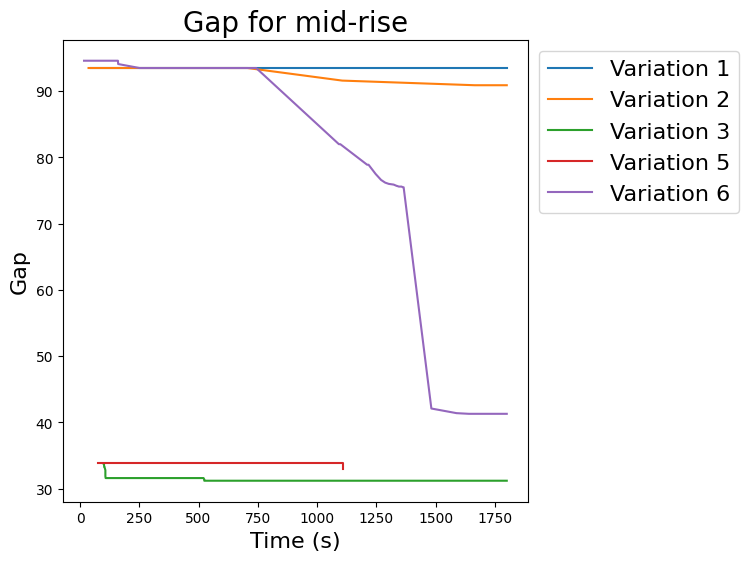

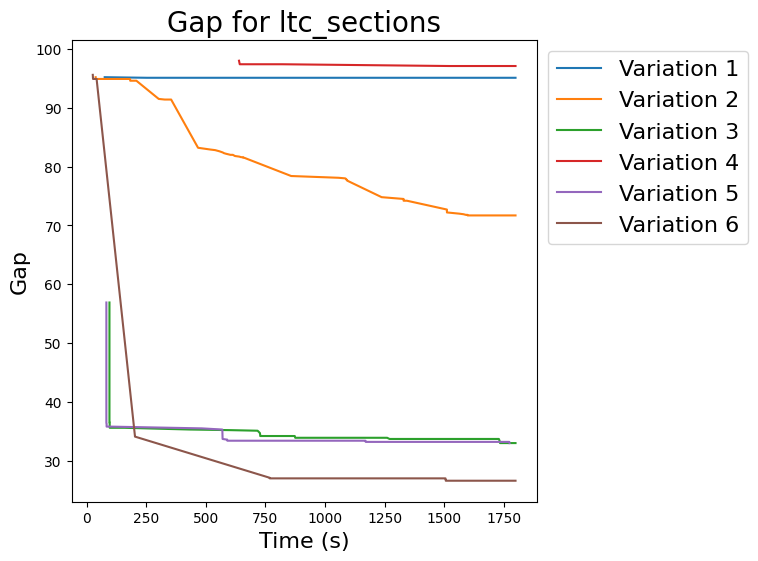

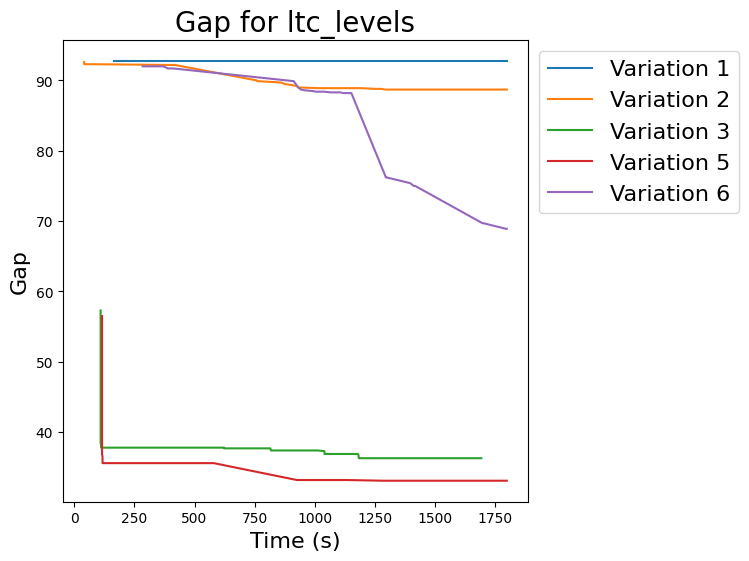

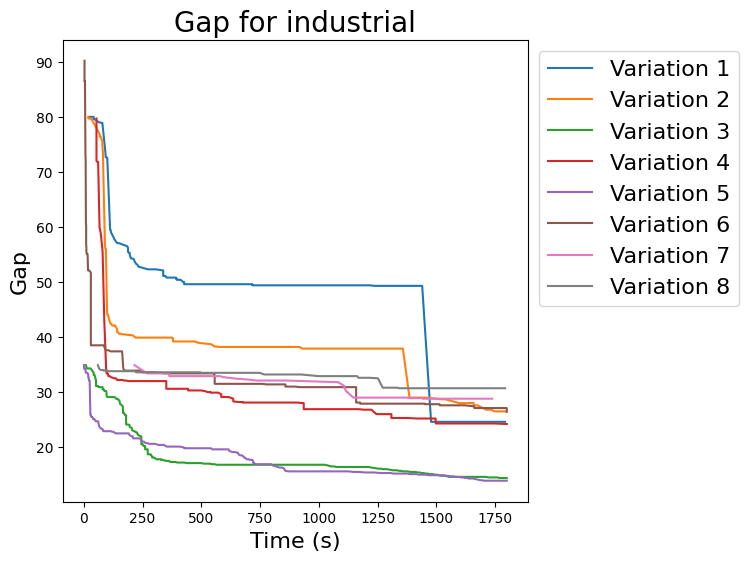

In [ ]:
instance_type = ["mid-rise", "ltc_sections", "ltc_levels", "industrial"]

opt = []
for key in data.keys():
  instance = data[key]["opt"]
  opt.append(instance)
ordered_variations = sorted(set(opt))

for instance in instance_type:
  plt.figure(figsize=(6,6))
  for i in ordered_variations:
    for key in data.keys():
      if data[key]["opt"] == i and instance in data[key]["instance"]:
        gap_over_time = data[key]["gap"]["gap"]
        time_kind = data[key]["gap"]["time"]
        if len(gap_over_time) != 0:
          plt.plot(time_kind, gap_over_time, label=f"Variation {i}")

  plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
  plt.title(f"Gap for {instance}", fontsize=20)
  plt.ylabel("Gap", fontsize=16)
  plt.xlabel("Time (s)", fontsize=16)
  plt.show()

As can be seen from the charts some models aren't drawn from 0 second, that is because they were stuck in the presolve stage up until the point that they are drawn. Some other models aren't drawn up until the end, that is because those models ran out of memory at the last point that they were drawn.

It can be seen that in all of our instances (apart from the _Industrial_ instance), most models didn't improve or change over time except model 6. Models 3 and 5 obtained the lowest gap from the very beginning for each instance, but didn't improve over time.

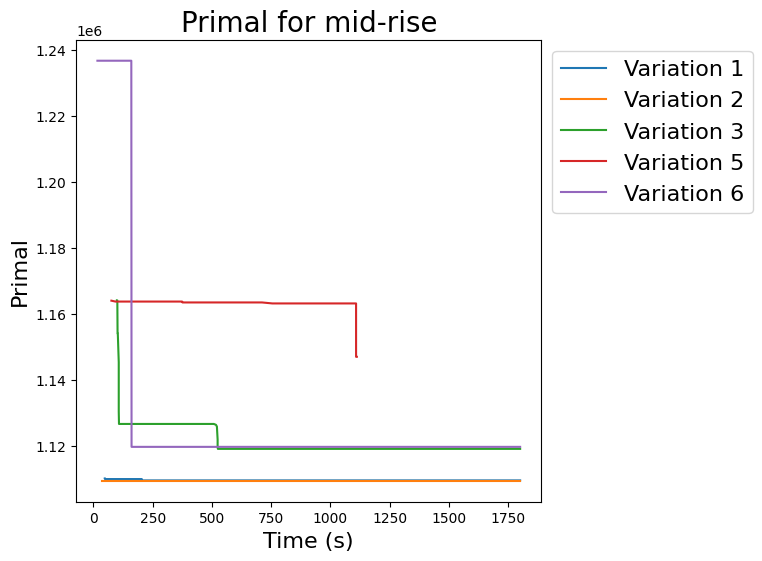

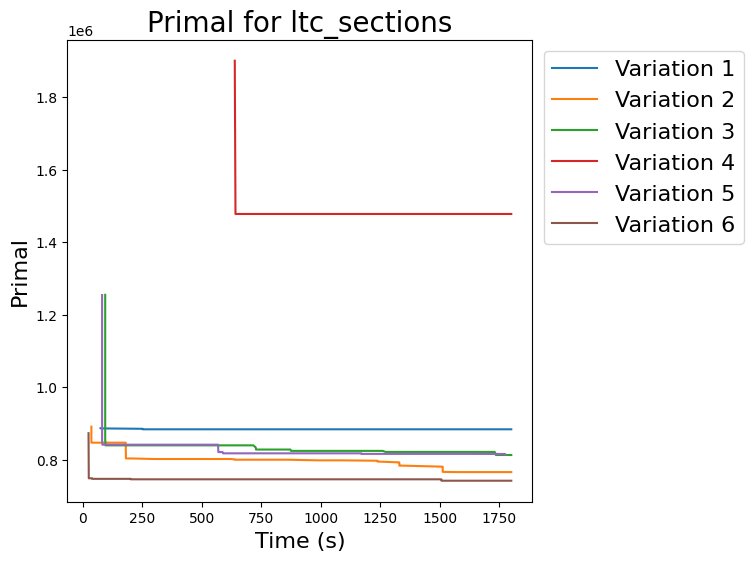

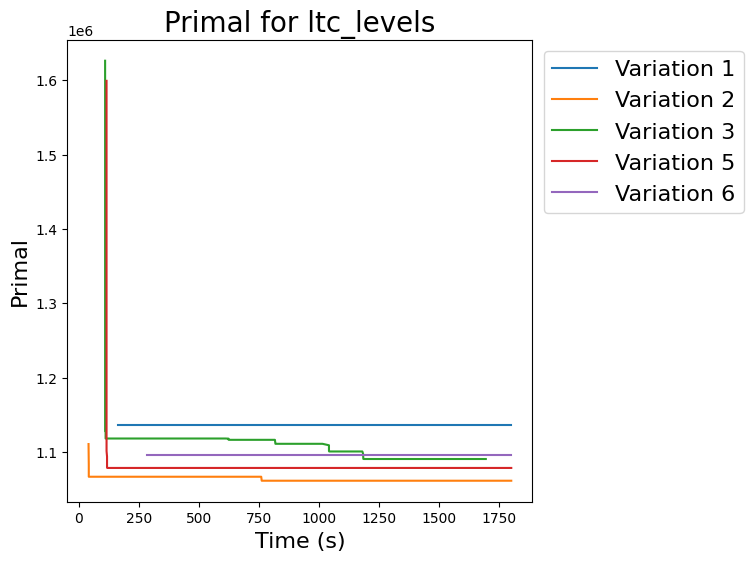

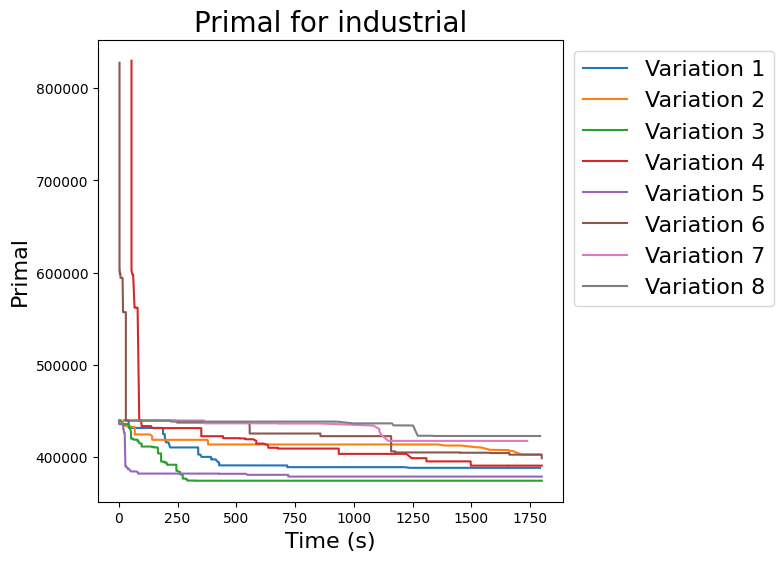

In [ ]:
for instance in instance_type:
  plt.figure(figsize=(6,6))
  for i in ordered_variations:
    for key in data.keys():
      if data[key]["opt"] == i and instance in data[key]["instance"]:
        gap_over_time = data[key]["primal"]["bound"]
        time_kind = data[key]["primal"]["time"]
        if len(gap_over_time) != 0:
          plt.plot(time_kind, gap_over_time, label=f"Variation {i}")

  plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
  plt.title(f"Primal for {instance}", fontsize=20)
  plt.ylabel("Primal", fontsize=16)
  plt.xlabel("Time (s)", fontsize=16)
  plt.show()

The primal value for all of our models almost didn't change at all over time, except for models 3, 5 and 6 which all had a steap initial improvement and then just plateaued. Comparing the results of the graphs for primal values and the gap values, we can once again conclude the main contribution of our best models was in regards with the dual of our problem.

# **Phase Two Improvements**

Phase two improvements stem from the idea that it is possible to know ahead of time, due to the geometric constraints of the problem, that some elements cannot be in the same group. This stems from the constraint that a group must be defined over a contiguous range of levels, and that if a group contains a column and a level, then the element at that column and level must exist and must be within a group (i.e. you cannot put an empty element into a group). From this, we can observe that, for two given elements $(c_i,l_i)$ and $(c_j, l_j)$ they may only be in the same group if $$e_{c_i l_j} = e_{c_j l_i} = 1$$. Which is to say, there must be an element in each other's column at each other's level. Otherwise, the above constraints are violated. This can be formulated as a clique constraint, such that $$x_{g c_i l_i} + x_{g c_j l_j} \leq 1 \forall g \in G$$. For two elements, we call this a 2-clique. The idea of clique constraints and their implementation in MIPs is not novel, and has been extensively studied by others for decades. This observation leads to two groups of improvements, detailed below.

## Partial Symmetry Breaking Constraints

### PSBC - Motivation

One issue with the initial formulation is there is a large degree of symmetry due to groups being interchangeable. For example, Group 1 containing elements {(1,3),(2,3)} and Group 2 containing elements {(1,3),(2,3)} is the same solution as Group 2 containing elements {(1,3),(2,3)} and Group 1 containing elements {(1,3),(2,3)}. This is for any combination of groups in the solution. It would be possible to break some of the symmetry by fixing certain elements to be in certain groups such that, for example, element (1,3) is always set to be in Group 1, and the rest of the groups are oriented around that. This is only possible to do if one knows a set of elements which are guarenteed to never be in the same group. Using the above clique constraint, we can extend this by generating a graph of all 2-cliques and finding the largest n-clique, and setting each element in that n-clique to be in a different group. In other words, we generate a conflict graph and find the maximum clique. This way, every element in the clique cannot be in a group with any other element, and n degrees of symmetry are removed. One problem with this, is that finding the maximum clique in a graph is NP-hard. We get around this by using an fast approxmation algorithm and, essentially, taking what we can get with that. The below code gives an example of that.

### PSBC - Implementation

First, we generate all 2-cliques by iterating through every element and checking against all other elements not in the same column or level (as that is trivially true). This generates a set $H_{i}$ of all the conflicting elements $(c,l)$ for a given element $(c_i, l_i)$.

In [5]:
import os
import json
folderpath = os.getcwd()
data_path = os.path.join(folderpath,"data.json")
instance = "1"

with open(data_path, 'r') as file:
    data = json.load(file)

i = instance
i_name = data[i]["name"]
test_data = data[i]["columns"]
n_cols = len(test_data)
n_levels = len(test_data[0])
E = {(i,j): 1 if test_data[i][j] > 0 else 0 for j in range(n_levels) for i in range(n_cols)}


def generate_cliques(col_exists):
    ## Returns a dictionary where key (c,l) returns a set of conflicting elements {(c,l)}
  infeasible_dict = dict()
  for (col,lvl) in col_exists:
    if col_exists[col,lvl] == 1:
      infeasible = set()
      for (col2,lvl2) in col_exists:
         if col2 != col and lvl2 != lvl and col_exists[col2, lvl2] == 1:
            if col_exists[col,lvl2] == 0 or col_exists[col2, lvl] == 0:
                infeasible.add((col2,lvl2))
      if len(infeasible) > 0:
        infeasible_dict[col,lvl] = infeasible

  return infeasible_dict

infeasible_dict = generate_cliques(E)

From there, we can use the networkx package to turn this into a graph and, using the max_clique approximation algorithm available in networkx, we can quickly find the approximately largest clique.

In [6]:
import networkx as nx
G = nx.Graph(infeasible_dict)
max_clique = nx.approximation.max_clique(G)

We can graph it to see what that looks like on the conflict graph, where vertex represents an element that exists in the problem (i.e. $e_{cl} = 1$) and every edge represents a conflict between those elements, as defined above.

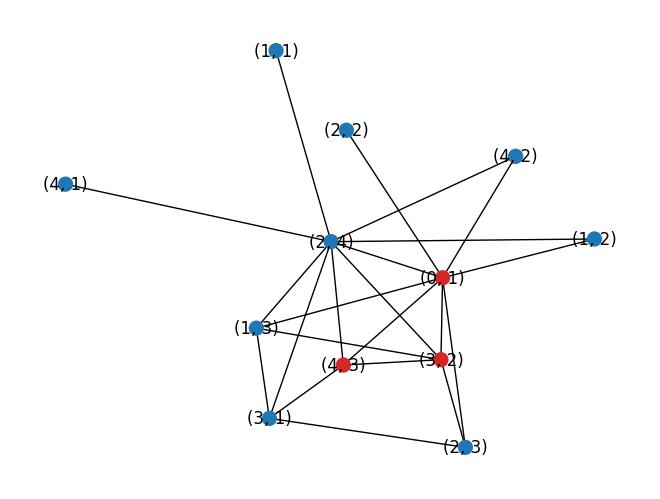

In [12]:
import matplotlib.pyplot as plt

node_cls = []
for n in G.nodes():
    if n in max_clique:
        node_cls.append("tab:red")
    else:
        node_cls.append("tab:blue")

nx.draw(G,with_labels=True,node_size=100, node_color=node_cls)
plt.show()

This does not always produce the best maximum clique, as it is an approximate algorithm. This is clear even in this small case (for Instance 1), where adding node (2,4) would increase the size of the clique. This is why it was called Partial SBC as there is no guarentee to break all the symmetry, only a portion of it. However, we decided this is good enough given the speed as finding the maximum clique may take expotential time in the worst case. To implement this into our model, we enumerate each element in the clique and add the following constraints to the model, as shown below.


In [ ]:
for g,(c,l) in enumerate(max_clique):
    model.addConstr(x[g,c,l] == 1)
    model.addConstr(group_exists[g] == 1)
    model.addConstr(column_in_group[g,c] == 1)
    model.addConstr(level_in_group[g,l] == 1)

This will break some symmetry, as we set $x_{gcl} = 1$ and the corresponding column to be within that group, level to be within that group, and group to exist. Improvements from this are shown in the results section for phase 2 improvements.


## Clique Constraints

Given this general idea stemming from the conflict graph, we came up with four potential implementations, detailed below.

### Clique Constraints - 2-Cliques

This comes directly from the **generate_cliques** function above. Here, we add one constraint for every 2-clique found, for every group, meaning the following constraints are added to the model $$x_{g c_i l_i} + x_{g c_j l_j} \leq 1 \quad \forall c_i \in C \quad l_i \in L \quad (c_j,l_j)  \in H_{i} \quad g \in G$$

For a given number of 2-cliques $a$, this would generate $a*|G|$ number of new constraints.

### Clique Constraints - Big M formulation

Another idea was, instead of constraining each element in a clique against each other element in a clique, to sum up all conflicting elements and add a constraint which specified that if any of the set of conflicting elements is in the group, the original element cannot be. This can be expressed with the following Big-M constraints, where $M_{i}=|H_{i}|$.

$$M_{ij}x_{g c_i l_i} + \sum_{(c_j,l_j)  \in H_{ij}}{c_j l_j} \leq M_{ij} \quad \forall c_i \in C \quad l_i \in L \quad  \forall g \in G$$

This creates many fewer constraints, but each constraint is not as tight of a formulation.

### Clique Constraints - Max Cliques

A third idea was to use the networkx implementation to find the maximum clique containing any given node and constrain that. $Q_{i}$ which contains the set of all elements $(c,l)$ that are in the maximum clique in the conflict graph containing element $(c_i, l_i)$, including the element $(c_i, l_i)$ itself. This may miss unique cliques of smaller sizes, but more effectively captures larger groups of clique constraints.

$$\sum_{(c,l)  \in Q_{i}} \leq 1 \quad \forall c_i \in C \quad l_i \in L \quad  \forall g \in G$$

### Clique Constraints - Column Cliques

Finally, we also noticed that when an element conflicts with another element, it also conflicts with any element in the entire column, as the conflict depends on the fact that the entire column does not have an element at that level. Thus, we can use the column_in_group binary variable and constrain that to our element_in_group variable instead. This uses a set $P_{i}$ which is the set of all unique columns in $H_{i}$.

$$x_{g c_i l_i} + cig_{c_j g} \leq 1 \quad \forall c_i \in C \quad l_i \in L \quad c_j  \in P_{i} \quad g \in G$$

## Clique Constriants - Implementation

These four constraints were generated using the following code, where **clique_2**, **clique_bigM**, **clique_max**, **clique_cols** are four binary variables initialized by the user to decide if any of the four clique constraints are added, respectfully.

In [ ]:
clique_2 = False
clique_bigM = False
clique_max = False
clique_cols = True

def clique_generator_columns(col_exists, ncol):
  #generates all cliques, but for entire columns only
  infeasible_dict = dict()
  for (col,lvl) in col_exists:
    if col_exists[col,lvl] == 1:
      infeasible = set()
      for col2 in range(ncol):
        if col_exists[col2,lvl] == 0:
            infeasible.add(col2)
      if len(infeasible) > 0:
        infeasible_dict[col,lvl] = infeasible
  return infeasible_dict

if clique_2:
  for [c,l], inf_set in infeasible_dict.items():
    if inf_set != {}:
      for [c2,l2] in inf_set:
        model.addConstrs(x[g,c,l] + x[g,c2,l2] <= 1 for g in range(max_min_groups))

if clique_bigM:
  for [c,l], inf_set in infeasible_dict.items():
    if inf_set != {}:
      M_grp = len(inf_set)
      model.addConstrs(M_grp*x[g,c,l] + gp.quicksum(x[g,c2,l2] for (c2,l2) in inf_set) <= M_grp for g in range(max_min_groups))

if clique_max:
  all_max_cliques = list(nx.find_cliques(G))
  for st in all_max_cliques:
    model.addConstrs(gp.quicksum(x[g,c,l] for (c,l) in st) <= 1 for g in range(max_min_groups))

if clique_cols:
  infeasible_dict_cols = clique_generator_columns(E,n_cols)
  for [c,l], inf_set in infeasible_dict_cols.items():
    if inf_set != {}:
      M_grp = len(inf_set)
      model.addConstrs(M_grp*x[g,c,l] + gp.quicksum(column_in_group[g,c2] for c2 in inf_set) <= M_grp for g in range(max_min_groups))


## Phase Two - Experimentation and Results

We took what we felt was the best performing model from Phase One (Variant 3 - with binary variables for element sections, but no continuous relaxations for some variables and no lazy called constraints) and performed an ablation study using each of the clique constraints and the partial symmetry breaking constraint. For this experiment we increased the allowable memory to 16 GiB, but decreased the time to 10 minutes per run, and focused on the instances "Industiral" and "Mid-Rise" due to time constraints. Gurobi's presolve was set to the "Conservative" setting as it was found that it often took longer to perform the presolve than the alloted time limit. The below table details the variation names in the experiment.

$$
\begin{array}{|c|c|c|c|c|c|}
\hline
\textbf{Clique Constraint:} & \text{None} & \text{Maximum} & \text{2-Clique} & \text{Big-M} & \text{Columns} \\
\hline
\text{Partial SBC} & \text{P-x} & \text{P-Max} & \text{P-2} & \text{P-M} & \text{P-Cols}  \\
\text{No Partial SBC} & \text{x-x} & \text{x-Max} & \text{x-2} & \text{x-M} & \text{x-Cols}  \\
\hline
\end{array}
$$

The overall final results from each run can be seen below, with the best result for each instance being bolded. Note that variant **x-max** could not be run for the **Mid-Rise** instance within the time limit, as it would time-out in Presolve. Therefore, for only this run was the model run without presolve.

**Table: Phase 2 Improvements - Summary**

|                |         | **x-x** | **x-Max** | **x-2** | **x-M** | **x-Cols** |   **P-x**   | **P-Max** |   **P-2**  | **P-M** | **P-Cols** |
|:--------------:|:-------:|:-------:|:---------:|:-------:|:-------:|:----------:|:-----------:|:---------:|:----------:|:-------:|:----------:|
| **Industrial** |  Primal |  394780 |   439451  |  430439 |  392399 |   389342   |    378890   |   447139  |   390840   |  403590 | **379473** |
|                |   Dual  |  286111 |   307758  |  312734 |  306076 |   296095   |    316592   |   327787  | **328677** |  328499 |   322622   |
|                |   Gap   |  27.5%  |   30.0%   |  27.3%  |  22.0%  |    23.9%   |    16.4%    |   26.7%   |    15.9%   |  18.6%  |  **15.0%** |
|  **Mid-Rise**  |  Primal | 1122582 |  1164744  | 1144728 | 1155976 |   1144654  | **1093168** |  1145755  |   1147219  | 1158965 |   1129647  |
|                |   Dual  |  770218 |    -710   |  491804 |  776442 |   800065   |    808178   |   807172  | **819314** |  807499 |   807269   |
|                |   Gap   |  31.4%  |   100.1%  |  57.0%  |  32.8%  |    30.1%   |  **26.1%**  |   29.6%   |    28.6%   |  30.3%  |    28.5%   |

Below, the improvement of each variant over the baseline model with no improvements (x-x) can be seen.

**Table: Phase 2 Improvements - Difference from Baseline Model**

|                |         | **x-x** | **x-Max** |  **x-2** |  **x-M**  | **x-Cols** |  **P-x**  | **P-Max** |  **P-2**  |  **P-M**  | **P-Cols** |
|:--------------:|:-------:|:-------:|:---------:|:--------:|:---------:|:----------:|:---------:|:---------:|:---------:|:---------:|:----------:|
| **Industrial** |  Primal |   0.0%  |   -11.3%  |   -9.0%  |  **0.6%** |  **1.4%**  |  **4.0%** |   -13.3%  |  **1.0%** |   -2.2%   |  **3.9%**  |
|                |   Dual  |   0.0%  |  **7.6%** | **9.3%** |  **7.0%** |  **3.5%**  | **10.7%** | **14.6%** | **14.9%** | **14.8%** |  **12.8%** |
|                |   Gap   |   0.0%  |   -8.9%   | **0.7%** | **20.1%** |  **13.0%** | **40.3%** |  **3.0%** | **42.2%** | **32.4%** |  **45.6%** |
|  **Mid-Rise**  |  Primal |   0.0%  |   -3.8%   |   -2.0%  |   -3.0%   |    -2.0%   |  **2.6%** |   -2.1%   |   -2.2%   |   -3.2%   |    -0.6%   |
|                |   Dual  |   0.0%  |  -100.1%  |  -36.1%  |  **0.8%** |  **3.9%**  |  **4.9%** |  **4.8%** |  **6.4%** |  **4.8%** |  **4.8%**  |
|                |   Gap   |   0.0%  |  -218.8%  |  -81.7%  |   -4.6%   |  **4.1%**  | **16.9%** |  **5.9%** |  **8.9%** |  **3.4%** |  **9.1%**  |


In [166]:
def get_json(urls, filename="results_phase2.json"):
  dt_list = []
  for url in urls:
    !wget -O $filename $url
    try:
        with open(filename, 'r') as f:
            dt = json.load(f)
    except FileNotFoundError:
        print(f"File {filename} not found.")
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    dt_list.append(dt)

  return dt_list

In [ ]:
# the url to the json file of the results
list_of_urls = ["https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_False_0.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_False_2.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_False_3.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_False_4.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_True_0.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_True_1.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_True_2.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_True_3.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/12_3_True_4.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_False_0.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_False_1.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_False_2.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_False_3.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_False_4.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_True_0.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_True_1.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_True_2.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_True_3.json",
                "https://raw.githubusercontent.com/mainbrm1380/MIE1603-1653/refs/heads/main/8_3_True_4.json"]

data_combined = get_json(list_of_urls)

In [ ]:
#12 is mid-rise, 8 is industrial
instance_12 = [dat[key] for dat in data_combined for key in dat.keys() if "12" in key]
instance_8 = [dat[key] for dat in data_combined for key in dat.keys() if "8" in key]

best_primal_12 = 1000000000

for inst in instance_12:
  if inst["primals"][-1] < best_primal_12:
    best_primal_12 = inst["primals"][-1]

best_primal_8 = 1000000000

for inst in instance_8:
  if inst["primals"][-1] < best_primal_8:
    best_primal_8 = inst["primals"][-1]

best_primal_8

colors_list_8 = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive", "cyan"]
colors_list_12 = ["blue", "orange", "green", "red", "purple", "brown", "pink", "gray", "olive"]

legend_lookup = {"T0":"P-x", "T1":"P-Max", "T2":"P-2", "T3":"P-M", "T4":"P-Cols",
                 "F0":"x-x", "F1":"x-Max", "F2":"x-2", "F3":"x-M", "F4":"x-Cols"}

def plot_metrics(instance, color_li, name):
  fig, axe = plt.subplots(1,2,figsize=(10,5))

  for i, color in enumerate(color_li):
    lb = str(instance[i]["bps"])[0]+str(instance[i]["clique_opt"])
    label = legend_lookup[lb]

    primal_vals = np.array(instance[i]["primals"])
    dual_vals = np.array(instance[i]["duals"])

    vals_to_be_plotted = (primal_vals-best_primal_12)/primal_vals
    dual_plotted = (primal_vals-dual_vals)/primal_vals

    axe[0].set_title(f"Primal of {name} instance")
    axe[1].set_title(f"Dual of {name} instance")

    axe[0].plot(instance[i]["times"], vals_to_be_plotted, color = color, label=label)
    axe[1].plot(instance[i]["times"], dual_plotted, color = color, label=label)

    axe[0].set_xlabel("Time (s)")
    axe[1].set_xlabel("Time (s)")

    axe[0].set_ylabel("Primal")
    axe[1].set_ylabel("Dual")

  plt.legend()
  plt.show()

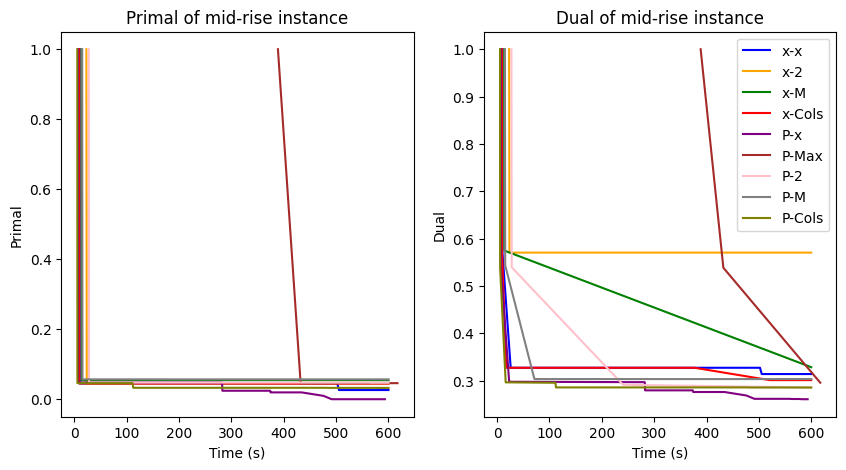

In [ ]:
plot_metrics(instance_12, colors_list_12, "mid-rise")

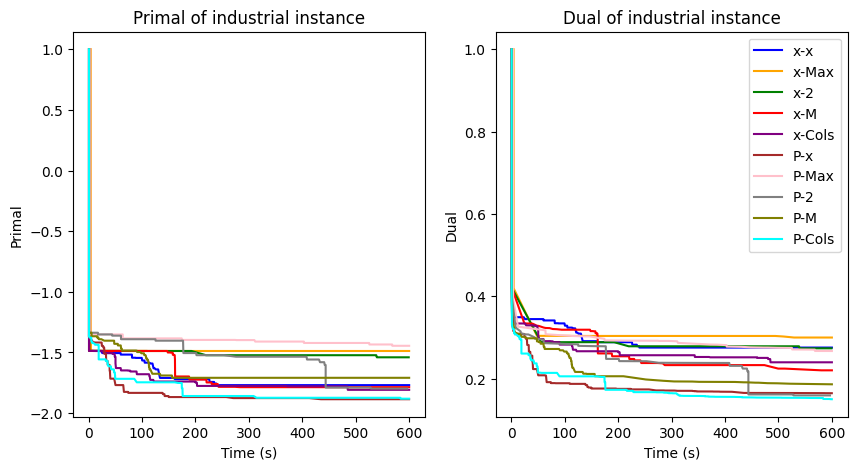

In [ ]:
plot_metrics(instance_8, colors_list_8, "industrial")

From these tables and graphs, we can see that almost all these improvements improve tighten the dual bound for both instances, which also, usually, improves the optimality gap. In the larger instance, $P-Cols$ and $P-x$ have the best performance over time, improving over $x-x$ in primal gap over time and optimality gap over time. However, only the variant  $P-Max$ improved the best primal bound in both instances. This shows there is some promise with these approaches, and they should be studied in greater depth with larger and more varied instances, on a longer time limit.

## Declaration of Contribution

Daniel and Mahdi agree that each team member has roughly contributed equally to the overall project. Both teammates enjoyed the project and hope to see it continued in future iterations of the course.

## Addendum - Vertex Colouring

One interesting note is that the problem of finding the minimum number of groups can be translated into the vertex colouring problems on the conflict graph, where the minimum number of groups is the minimum number of colours needed to colour the conflict graph such that no two colours touch, i.e. the chromatic number of the conflict graph. While this is interesting, and could potentially be touched upon to further strengthen the formulation in future work, this was not touched upon in our work, as we did not want to constrain the optimization to only use the minimum number of groups and we used our own heuristic to find the maximum number of allowable groups.